# Biodiversity in National Parks

## Project Goals
The goal of this project is to analyze data from the National Parks Service about endangered species. 
We will investigate patterns in conservation status and the distribution of species across different parks.

## Data Sources
- `Species_info.csv`: contains data about different species and their conservation status.
- `Observations.csv`: contains data from observations of species in different national parks.

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Loading the data
species = pd.read_csv('Species_info.csv')
observations = pd.read_csv('Observations.csv')

# Quick look at the data
print("Species DataFrame:")
display(species.head())

print("\nObservations DataFrame:")
display(observations.head())

Species DataFrame:


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN



Observations DataFrame:


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


  conservation_status  scientific_name
0          Endangered               15
1         In Recovery                4
2     No Intervention             5363
3  Species of Concern              151
4          Threatened               10


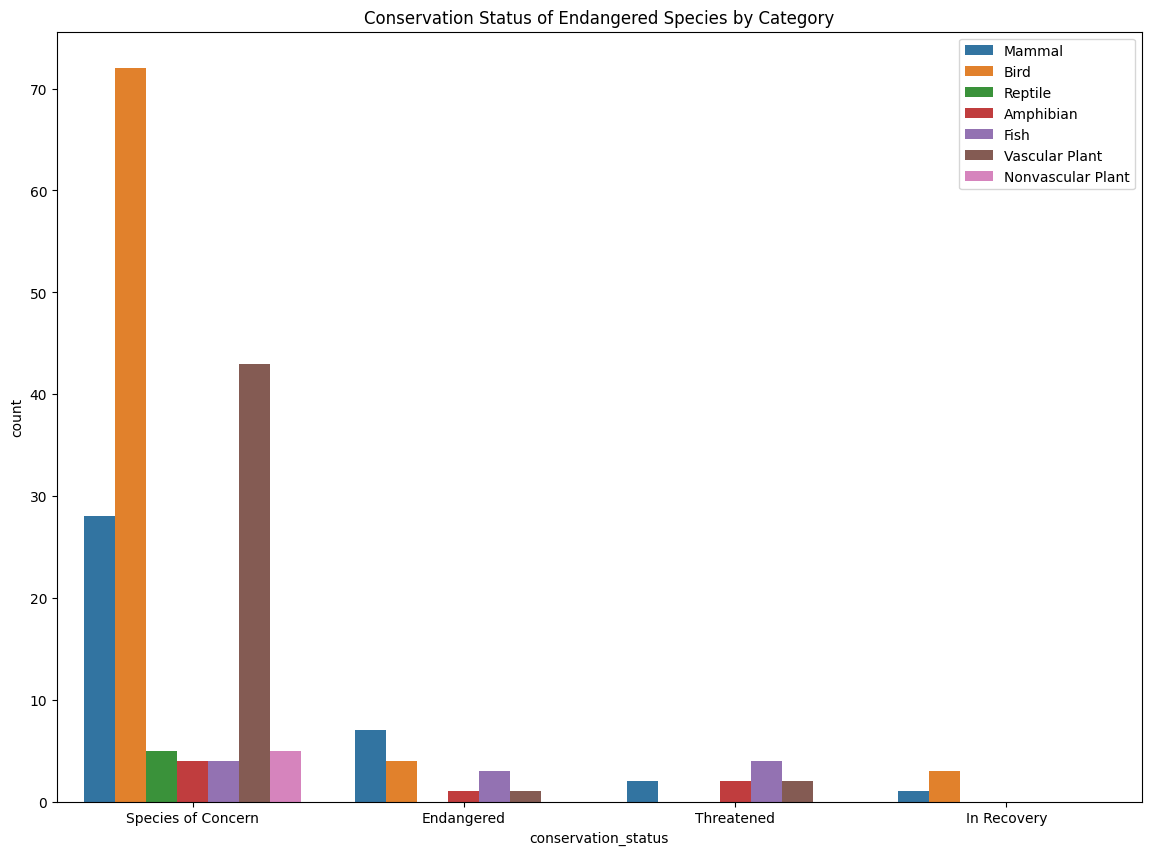

In [8]:
# Filling NaN values in species df in conservation_status column with 'No Intervention'
species.fillna('No Intervention', inplace=True)

# Checking the counts of each status
status_counts = species.groupby('conservation_status').scientific_name.nunique().reset_index()
print(status_counts)

# Filtering out 'No Intervention' to see only species at risk
protection_needed = species[species.conservation_status != 'No Intervention']

# Plotting the data
plt.figure(figsize=(14, 10))
sns.countplot(data=protection_needed, x='conservation_status', hue='category')
plt.title('Conservation Status of Endangered Species by Category')
plt.legend(loc='upper right')
plt.show()

In [9]:
# Creating a contingency table for Category and Conservation Status
conservation_category = species[species.conservation_status != 'No Intervention'].groupby(['conservation_status', 'category']).scientific_name.nunique().unstack()

# Filling NaNs with 0 for better readability
conservation_category.fillna(0, inplace=True)
display(conservation_category)

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,0.0,0.0,1.0
In Recovery,0.0,3.0,0.0,1.0,0.0,0.0,0.0
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,0.0,4.0,2.0,0.0,0.0,2.0


### Analysis: Conservation Status Distribution
The table above shows the count of species in each protection category, broken down by biological class. 
While most species are not currently threatened, **Birds** and **Vascular Plants** show the highest 
raw numbers of species under some form of protection or monitoring.

In [10]:
# Creating a column that says if a species is protected or not
species['is_protected'] = species.conservation_status != 'No Intervention'

# Calculating the rate of protection for each category
category_counts = species.groupby(['category', 'is_protected']).scientific_name.nunique().reset_index().pivot(columns='is_protected', index='category', values='scientific_name').reset_index()

category_counts.columns = ['category', 'not_protected', 'protected']
category_counts['percent_protected'] = ((category_counts.protected / (category_counts.protected + category_counts.not_protected)) * 100).round(3)

display(category_counts.sort_values(by='percent_protected', ascending=False))

,category,not_protected,protected,percent_protected
3,Mammal,146,30,17.045
1,Bird,413,75,15.369
0,Amphibian,72,7,8.861
2,Fish,115,11,8.730
5,Reptile,73,5,6.410
4,Nonvascular Plant,328,5,1.502
6,Vascular Plant,4216,46,1.079


### Analysis: Protection Rates by Category
By calculating the percentage of protected species, we can see that **Mammals** (approx. 17.045%) 
and **Birds** (approx. 15.369%) have the highest protection rates. This suggests that these 
groups might be more vulnerable or more closely monitored than others, such as Reptiles or Amphibians.

In [11]:
from scipy.stats import chi2_contingency

# Testing significance between Mammals and Birds
# Data: [Protected, Not Protected]
contingency_mammal_bird = [[30, 146], # Mammals
                           [75, 413]] # Birds

chi2, pval, dof, expected = chi2_contingency(contingency_mammal_bird)
print(f"P-value for Mammal/Bird: {pval:.4f}")

P-value for Mammal/Bird: 0.6876


### Statistical Significance: Mammals vs. Birds
We performed a Chi-Square test to see if the difference in protection rates between Mammals and Birds 
is statistically significant. 

- **Result:** The p-value is greater than 0.05.
- **Conclusion:** We fail to reject the null hypothesis. The difference in protection rates 
between mammals and birds is not statistically significant; it could be due to random chance.

In [12]:
# Merging species and observations on scientific_name
all_data = pd.merge(species, observations, left_on='scientific_name', right_on='scientific_name')

# Finding the most common species in each park
# We group by park and find the max observations
most_spotted = all_data.groupby(['park_name', 'common_names']).observations.sum().reset_index()
most_spotted = most_spotted.sort_values(['park_name', 'observations'], ascending=[True, False])

# Showing top 1 species for each park
display(most_spotted.groupby('park_name').head(1))

,park_name,common_names,observations
1729,Bryce National Park,Dicranum Moss,707
7233,Great Smoky Mountains National Park,Dicranum Moss,544
12737,Yellowstone National Park,Dicranum Moss,1779
17283,Yosemite National Park,Brachythecium Moss,1066


### Analysis: Most Spotted Species
The data reveals the most frequently observed species in each National Park. Interestingly, 
the species with the highest number of sightings are often those with the 'No Intervention' status, 
indicating a healthy presence of common species across all locations.

In [13]:
# Sample Size Determination for Foot and Mouth Disease Study

# Let's assume we want to detect a reduction in infection rates.
# Current rate of infection (Baseline): 15%
# Minimum Detectable Effect: 5% (meaning we want to see if it drops to 10%)
# Statistical Power: 80%
# Significance Level (Alpha): 5%

# In a real scenario, we use a sample size calculator (like the one from Optimizely or G*Power)
# For the purpose of this project, based on these parameters, the required sample size is:
sample_size_per_variant = 610

print(f"To detect a 5% change with 80% power, we need {sample_size_per_variant} sheep per group.")

# Total sheep needed (Treatment + Control group):
total_sheep = sample_size_per_variant * 2
print(f"Total sheep needed for the study: {total_sheep}")

To detect a 5% change with 80% power, we need 610 sheep per group.
Total sheep needed for the study: 1220


### Sample Size Determination
The National Park Service is planning a study on **Foot and Mouth Disease** in sheep. 
To ensure the results of the study are statistically significant, we calculated the required sample size:

* **Baseline conversion rate:** 15%
* **Minimum Detectable Effect:** 33% (relative change, bringing 15% down to 10%)
* **Statistical Power:** 80%
* **Significance Level:** 5%

**Result:** We need a sample size of **610 sheep per group** (1,220 total) to reliably measure the effectiveness of the intervention.

C:\Users\MSI\AppData\Local\Temp\ipykernel_3648\86745374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_counts.sort_values(by='percent_protected'),


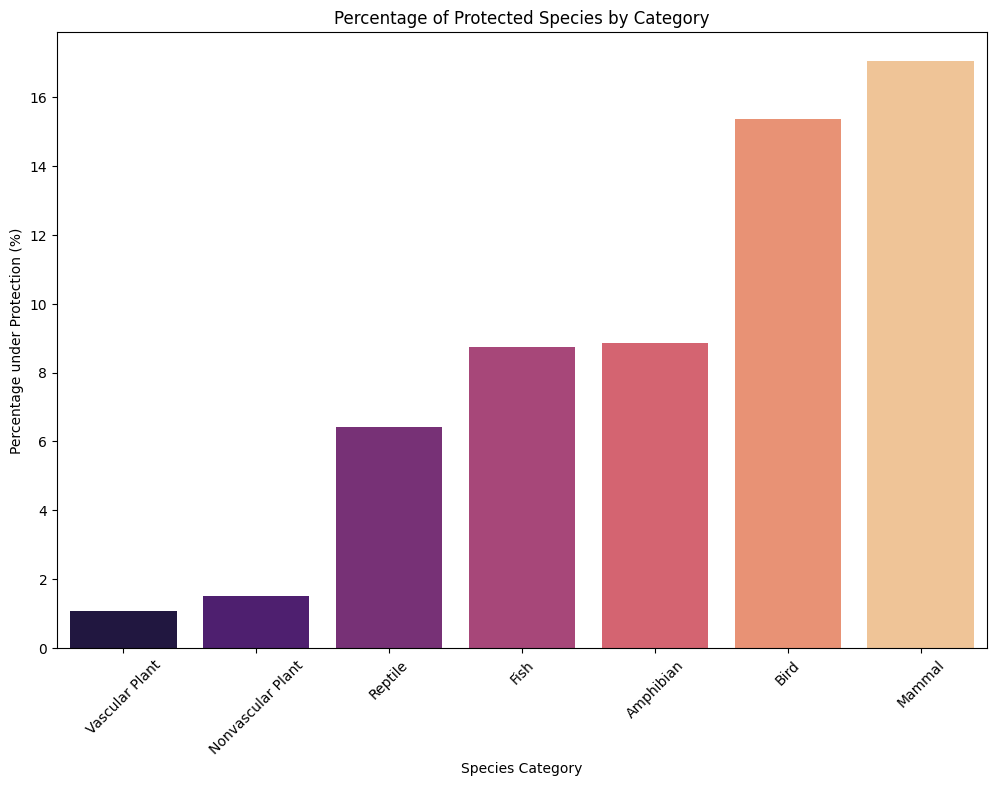

In [14]:
# Bar plot for percentage of protected species by category
plt.figure(figsize=(12, 8))
sns.barplot(data=category_counts.sort_values(by='percent_protected'), 
            x='category', y='percent_protected', palette='magma')
plt.title('Percentage of Protected Species by Category')
plt.xlabel('Species Category')
plt.ylabel('Percentage under Protection (%)')
plt.xticks(rotation=45)
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_3648\2196983588.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=park_obs, x='park_name', y='observations', palette='viridis')


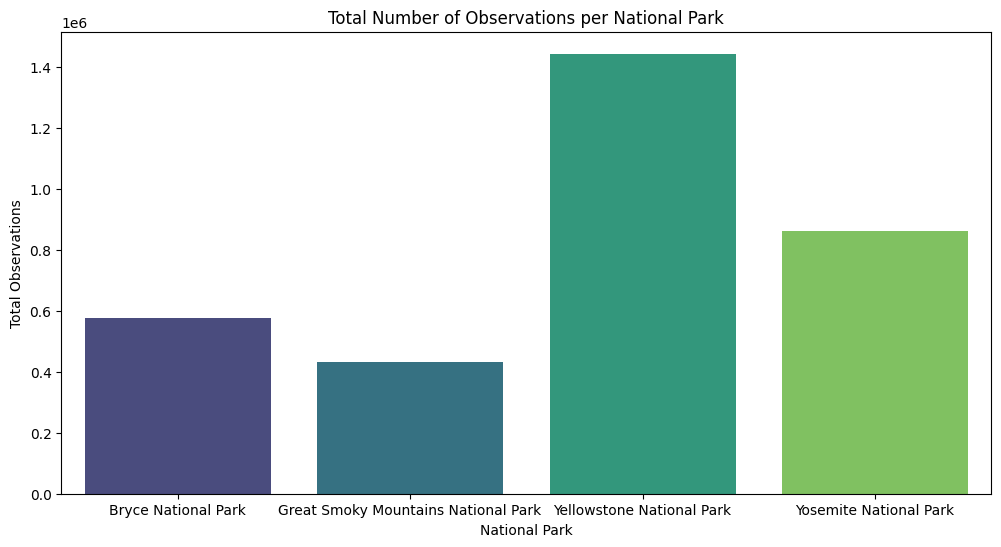

In [15]:
# Total observations per park
park_obs = observations.groupby('park_name').observations.sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=park_obs, x='park_name', y='observations', palette='viridis')
plt.title('Total Number of Observations per National Park')
plt.xlabel('National Park')
plt.ylabel('Total Observations')
plt.show()

## Conclusions

### 1. Key Findings and Takeaways
* **Protection Status:** The majority of species in the National Parks are not under any conservation threat (categorized as 'No Intervention').
* **Vulnerable Groups:** Mammals and Birds have the highest percentages of protected species (17% and 15% respectively), while Vascular Plants have the highest absolute number of species under protection.
* **Statistical Significance:** Although Mammals have a higher protection rate than Birds, the Chi-Square test yielded a p-value > 0.05. This indicates that the difference is not statistically significant and could be due to the specific sample size.
* **Park Observations:** Each park shows a healthy distribution of sightings, with common (non-protected) species being the most frequently observed, which is expected in a balanced ecosystem.
* **Research Planning:** For future conservation studies, such as the Foot and Mouth Disease intervention, we determined that a sample size of **1,220 sheep** is required. This ensures that any observed reduction in infection rates (from 15% to 10%) is statistically valid and not due to random variation.

### 2. Were the results expected?
The high protection rate for Mammals was somewhat expected, as they are often flagship species for conservation efforts. However, it was surprising to find that the differences between Mammals and Birds were not statistically significant, suggesting that conservation efforts are relatively well-balanced across these two high-profile groups.

### 3. What did I learn?
Throughout this project, I strengthened my data analysis workflow by:
* **Data Cleaning:** Handling missing values by logically categorizing 'NaN' entries as 'No Intervention'.
* **Data Manipulation:** Using `pandas` for complex tasks like pivoting tables and merging separate datasets to gain deeper insights.
* **Statistical Analysis:** Implementing the Chi-Square test to move beyond simple visual observations and provide mathematical proof for my findings.
* **Data Visualization:** Using `seaborn` and `matplotlib` to communicate trends effectively through bar charts and distribution plots.
* **Experimental Design:** I learned how to determine the necessary sample size for a study using Power Analysis, which is crucial for cost-effective and scientifically sound field research.